In [89]:

from END_cv_functions import *


In [90]:
u = mda.Universe("md.tpr", "md.xtc")
print(f"{u}, unlike in the paper it reports 39768 atoms\n  However the protein atoms is {len(u.select_atoms('protein'))} same as the paper" )
time_step = u.trajectory.dt 
print(f"The frame interval for the trajectories is : {time_step} ps" )
print(f"The system has {u.trajectory.n_frames} frames")
print(f"The total simulation time is 81 x 5 = {len(u.trajectory)*u.trajectory.dt} ps\n   The paper reports saving a frame every 400ps which mean in this work we can only reproduce the first frame , equivilant to frame number 200.\n   However to test the code, more frames are needed, therefore, a frame every 40ps will be selected. ")
protein = u.select_atoms("protein")

protein_residues = protein.residues
print(f"The system has {len(protein_residues)} residues")
for residue in protein_residues:
    print(f"{ residue.resid}, {residue.resname}")

<Universe with 8339 atoms>, unlike in the paper it reports 39768 atoms
  However the protein atoms is 304 same as the paper
The time step for the trajectories is : 5.0 ps
The system has 81 frames
The total simulation time is 81 x 5 = 405.0 ps
   The paper reports saving a frame every 400ps which mean in this work we can only reproduce the first frame , equivilant to frame number 200.
   However to test the code, more frames are needed, therefore, a frame every 40ps will be selected. 
The system has 20 residues
1, ASN
2, LEU
3, TYR
4, ILE
5, GLN
6, TRP
7, LEU
8, LYS
9, ASP
10, GLY
11, GLY
12, PRO
13, SER
14, SER
15, GLY
16, ARG
17, PRO
18, PRO
19, PRO
20, SER


The code below computes:  
* eigen values  
* eigen vectors  
* ENG(t) gap per frame.  
* SDENG(t) per frame. 
* A dictionary of eigen vectors  

All form a selcetion of frames.


In [91]:

lj_params = extract_lj_parameters("topol.txt")

interval_ps = 40  # unit: ps
interval_frames = int(interval_ps / time_step)
selected_frames = list(range(0, u.trajectory.n_frames, interval_frames))
eng_list = []
sdeng_list = []

components = {} 

for frame_index, frame in enumerate(selected_frames):
    u.trajectory[frame]  
    distance_matrix, residue_ids = compute_distance_matrix(u, protein_residues)

    energy_matrix = compute_interaction_energy_matrix(distance_matrix, protein_residues, lj_params, dielectric=78.5)
    eigen_values, eigen_vectors = np.linalg.eigh(energy_matrix)

    min_index = np.argmin(eigen_values)

    frame_key = f"frame_{frame_index + 1}"
    vector_key = f"v{min_index + 1}"

    # Initialize a counter for residue names
    residue_counter = {}
    modified_residue_ids = []
    for i, (index, name) in enumerate(residue_ids):
        if name in residue_counter:
            residue_counter[name] += 1
            new_name = f"{name}_{residue_counter[name]}"
        else:
            residue_counter[name] = 0
            new_name = name
        modified_residue_ids.append((index, new_name))

    components[frame_key] = {vector_key: {mod_id: value for mod_id, value in zip(modified_residue_ids, eigen_vectors[:, min_index])}}

    eng, sdeng = calculate_eng_sdeng(eigen_values)
    eng_list.append(eng)
    sdeng_list.append(sdeng)




In [88]:
# components
# eng_list

* Picks out the eigen vectos corresponding to the least eigen values in each of the selected frames.

In [ ]:

residue_data = {}

# Iterate over each frame in the components dictionary
for frame_key, vectors in components.items():
    for vector_key, residues in vectors.items():
        # Iterate over each residue in the vector
        for (residue_id, residue_name), value in residues.items(): 
            if residue_name not in residue_data:
                # If not, initialize it with an empty list
                residue_data[residue_name] = []
            residue_data[residue_name].append(value)

In [92]:
# residue_data

# Result 1:  

* ENG(t) vs time  
* SDENG(t) vs time 

Text(0.5, 0, 'time (ps)')

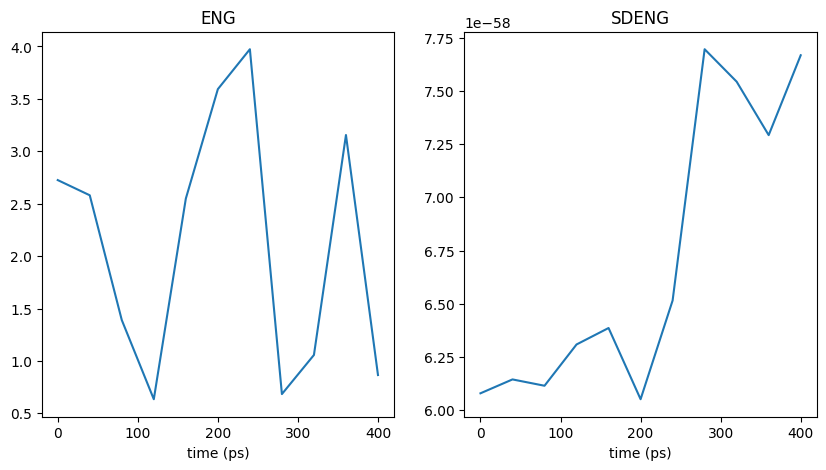

In [99]:
# time = np.linspace(0, len(eng_list) * interval_ps, len(eng_list))
time_step = 40 
time = [i * time_step for i in range(len(next(iter(residue_data.values()))))]
# time = [i * u.trajectory.dt for i in range(u.trajectory.n_frames)]
fig, ax =plt.subplots(1,2,figsize=(10, 5))

ax[0].plot(time, eng_list)
ax[0].set_title("ENG")
ax[0].set_xlabel("time (ps)")
ax[1].plot(time, sdeng_list)
ax[1].set_title("SDENG")
ax[1].set_xlabel("time (ps)")

In [95]:
eng_list = []
sdeng_list = []

components = {}  # Main dictionary to hold all frame data

# Variables to find the frame with the highest ENG and the lowest SDENG
max_eng = -np.inf
min_sdeng = np.inf
frame_with_max_eng = None
frame_with_min_sdeng = None

for frame_index, frame in enumerate(selected_frames):
    u.trajectory[frame] 
    distance_matrix, residue_ids = compute_distance_matrix(u, protein_residues)

    energy_matrix = compute_interaction_energy_matrix(distance_matrix, protein_residues, lj_params, dielectric=78.5)
    eigen_values, eigen_vectors = np.linalg.eigh(energy_matrix)

   
    min_index = np.argmin(eigen_values)

    # Initialize a dictionary for this frame
    frame_key = f"frame_{frame_index + 1}"
    vector_key = f"v{min_index + 1}"

    # Initialize a counter for residue names
    residue_counter = {}
    modified_residue_ids = []
    for i, (index, name) in enumerate(residue_ids):
        if name in residue_counter:
            residue_counter[name] += 1
            new_name = f"{name}_{residue_counter[name]}"
        else:
            residue_counter[name] = 0
            new_name = name
        modified_residue_ids.append((index, new_name))

    components[frame_key] = {vector_key: {mod_id: value for mod_id, value in zip(modified_residue_ids, eigen_vectors[:, min_index])}}

    eng, sdeng = calculate_eng_sdeng(eigen_values)
    eng_list.append(eng)
    sdeng_list.append(sdeng)

    # Update the frame with the highest ENG and the lowest SDENG
    if eng > max_eng:
        max_eng = eng
        frame_with_max_eng = frame_index + 1  # Adjusted for 1-based index to match your frame naming
    if sdeng < min_sdeng:
        min_sdeng = sdeng
        frame_with_min_sdeng = frame_index + 1

# Print the frame numbers with the highest ENG and the lowest SDENG values
print(f"The frame with the highest ENG value is frame_{frame_with_max_eng} with an ENG value of {max_eng:.2f}")
print(f"The frame with the lowest SDENG value is frame_{frame_with_min_sdeng} with an SDENG value of {min_sdeng:.2f}")

# Additional print to show if they coincide
if frame_with_max_eng == frame_with_min_sdeng:
    print("The frame with both the highest ENG and the lowest SDENG is the same: Frame", frame_with_max_eng)
else:
    print("No single frame has both the highest ENG and the lowest SDENG simultaneously.")


The frame with the highest ENG value is frame_7 with an ENG value of 3.97
The frame with the lowest SDENG value is frame_6 with an SDENG value of 0.00
No single frame has both the highest ENG and the lowest SDENG simultaneously.


In [96]:
selected_frames = list(range(0, u.trajectory.n_frames, interval_frames))
time_points_ns = [frame * time_step / 1000.0 for frame in selected_frames]  # Convert each frame time point to ns

# Print or process the time points
for frame, time_ns in zip(selected_frames, time_points_ns):
    print(f"Frame {frame} corresponds to {time_ns} ns")

Frame 0 corresponds to 0.0 ns
Frame 8 corresponds to 0.04 ns
Frame 16 corresponds to 0.08 ns
Frame 24 corresponds to 0.12 ns
Frame 32 corresponds to 0.16 ns
Frame 40 corresponds to 0.2 ns
Frame 48 corresponds to 0.24 ns
Frame 56 corresponds to 0.28 ns
Frame 64 corresponds to 0.32 ns
Frame 72 corresponds to 0.36 ns
Frame 80 corresponds to 0.4 ns


# Result 2:  
* Plotting the components of all the residues vs time to see their evolution.
<!-- * Correlation distance plots for each residue in it's unique position in the protein through all selected frames. (Supposidly the crucial frames)   -->




/var/folders/t5/cty4pmdx4fzgbbz0ptr_q2z40000gn/T/ipykernel_19307/3593986877.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_residues)  # Get 'n_residues' colors from the 'tab20' colormap


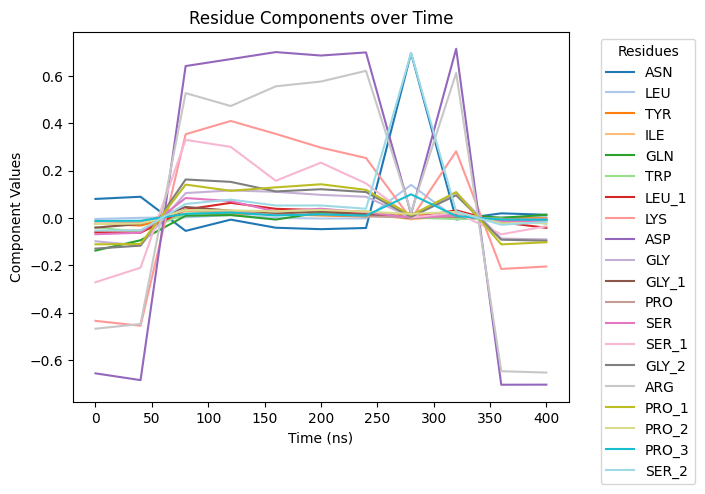

In [81]:

n_residues = len(residue_data)  
colors = cm.get_cmap('tab20', n_residues)  # Get 'n_residues' colors 

fig, ax = plt.subplots()
for i, (residue, values) in enumerate(residue_data.items()):
    ax.plot(time, values, label=residue, color=colors(i / n_residues))  # Normalize index for color map

ax.set_xlabel('Time (ns)')
ax.set_ylabel('Component Values')
ax.set_title('Residue Components over Time')
ax.legend(title='Residues', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Result 3:  
* Computing if the residue component values correlate or anti correlate witht the ENG(t) ove rtime 

In [ ]:

residue_correlations = {}
for residue, values in residue_data.items():
    rho = calculate_pearson_correlation(eng_list, values)
    cd = calculate_correlation_distance(rho)
    residue_correlations[residue] = {'Correlation Coefficient': rho, 'Correlation Distance': cd}

sorted_residues = sorted(residue_correlations.items(), key=lambda item: item[1]['Correlation Distance'])


correlation_df = pd.DataFrame({
    'Residue': [res[0] for res in sorted_residues],
    'Correlation Coefficient': [res[1]['Correlation Coefficient'] for res in sorted_residues],
    'Correlation Distance': [res[1]['Correlation Distance'] for res in sorted_residues]
})



In [97]:
# correlation_df

,Residue,Correlation Coefficient,Correlation Distance
0,TRP,0.095479,1.345007
1,ARG,0.020521,1.399628
2,PRO_1,-0.015837,1.425368
3,ASP,-0.022440,1.429993
4,GLY,-0.080936,1.470331
5,GLY_2,-0.088960,1.475778
6,PRO_2,-0.106012,1.487287
7,ILE,-0.126208,1.500805
8,SER_1,-0.129922,1.503278
9,LYS,-0.131437,1.504285


# Result 4:  
Finding the threshold from which we can identify the frames of values less than max ENG(t) and greater that min SDENG(t).  

 
It aims to quantify how many data points (conformations) lie within varying thresholds, providing insights into the concentration and spread of data points around these extremes.  



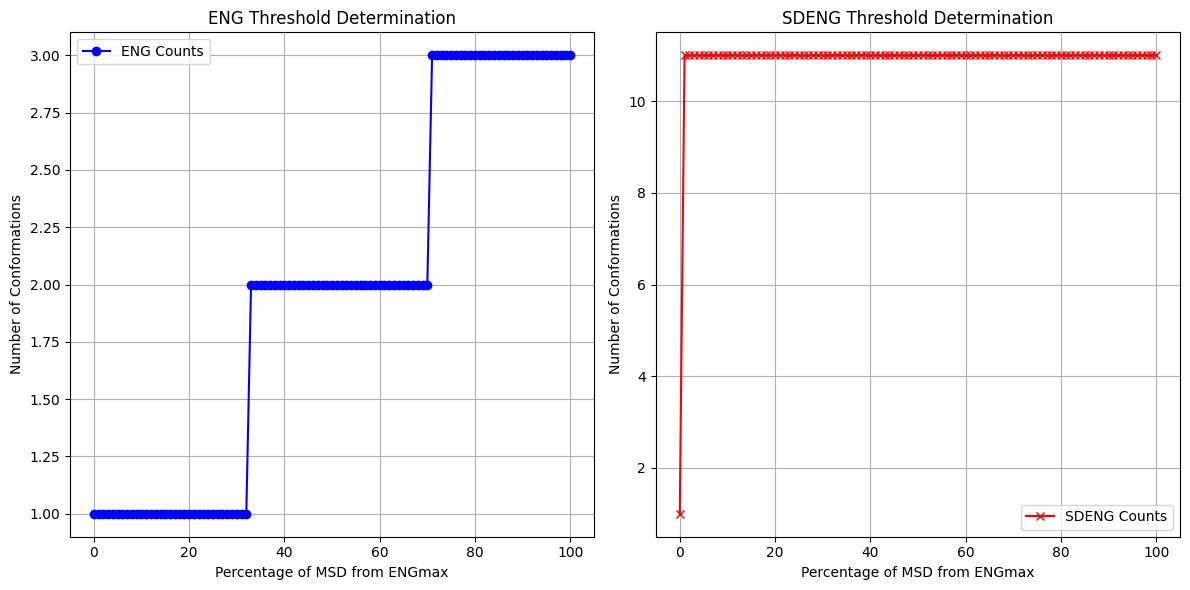

In [93]:
 
# Optimal window size determination and smoothing
optimal_window_size_eng = determine_optimal_window(eng_list)
optimal_window_size_sdeng = determine_optimal_window(sdeng_list)

smoothed_eng = calculate_moving_average(eng_list, )
smoothed_sdeng = calculate_moving_average(sdeng_list, optimal_window_size_sdeng)



determine_thresholds(np.array(eng_list), np.array(sdeng_list))
